**EDA & Model Building on Telecommunication Data**

The goal is to perform **EDA (Exploratory Data Analysis)** on **Customer Churn Data** within the **Telcommunication industry,** and then build prediciton models to determine the customers most likely to churn.

The prediction models built were Naive Bayes, Logistic Regression, Random Forest, and XGBoost. The metrics of performance for the models are accuracy, precision, recall, and F1.

The dataset contains 7043 rows and 21 columns.

The features are CustomerID; gender; SeniorCitizen; Partner; Dependent; PhoneService; MultipeLines; InternetService; OnlineSecurity; OnlineBackup; DeviceProtection; TechSupport; StreamingTV; StreamingMovies; Contract; PaperlessBilling; PaymentMethod; Tenure; MonthlyCharges; TotalCharges; and the prediction feature, Churn.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

import warnings
warnings.filterwarnings("ignore")

In [2]:
telco = pd.read_csv("telco-customer-churn.csv")

**Prepare data for EDA and model-building.  Looking for missing, null, NaN records.**

In [3]:
telco.shape

(7043, 21)

In [4]:
len(telco["customerID"].unique())

7043

In [5]:
telco.head(3)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   

      PaymentMethod MonthlyCharges  TotalCharges Churn  
0  Electronic check          29.85         29.85    No  
1      Mailed check          56.95        1889.5    No  
2      Mailed check          53.85        108.15   Yes  

[3 rows x 21 columns]

In [6]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
print(telco["TotalCharges"].isnull().any())

False


**Transform data - all entries should be numeric.**

In [8]:
telco["TotalCharges"] = pd.to_numeric(telco["TotalCharges"], errors = "coerce")

In [9]:
mask = False
for col in telco.columns:
    mask = mask | telco[col].isnull()
telcoNulls = telco[mask]

In [10]:
# if tenure = 0 AND TotalCharges = NAN, TotalCharges = MonthlyCharges, assuming they have not received their first bill yet

t = telco.TotalCharges.fillna(telco.MonthlyCharges, inplace = True)
print(t)

None


In [11]:
print(telco["TotalCharges"].isnull().any())

False


In [12]:
from sklearn.preprocessing import LabelEncoder

telco2 = telco.copy()

numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
categoricalColumns = []
features = telco.columns.values.tolist()

for col in features:
    if telco[col].dtype in numerics: continue
    categoricalColumns.append(col)

for col in categoricalColumns:
    if col in telco.columns:
        le = LabelEncoder()
        le.fit(list(telco[col].astype(str).values))
        telco[col] = le.transform(list(telco[col].astype(str).values))

In [13]:
telco[["tenure", "MonthlyCharges", "TotalCharges"]].describe().T

count         mean          std    min     25%      50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.00    29.00   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.50    70.35   
TotalCharges    7043.0  2279.798992  2266.730170  18.80  398.55  1394.55   

                    75%      max  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80

**Find outliers.**

In [14]:
Q1 = telco[["tenure", "MonthlyCharges", "TotalCharges"]].quantile(0.25)
print(Q1)

tenure              9.00
MonthlyCharges     35.50
TotalCharges      398.55
Name: 0.25, dtype: float64


In [15]:
Q3 = telco[["tenure", "MonthlyCharges", "TotalCharges"]].quantile(0.75)
print(Q3)

tenure              55.00
MonthlyCharges      89.85
TotalCharges      3786.60
Name: 0.75, dtype: float64


In [16]:
IQR = Q3 - Q1
print(IQR)

tenure              46.00
MonthlyCharges      54.35
TotalCharges      3388.05
dtype: float64


**Performing EDA on data.**

Present dependencies and correlations among the various features in the data.

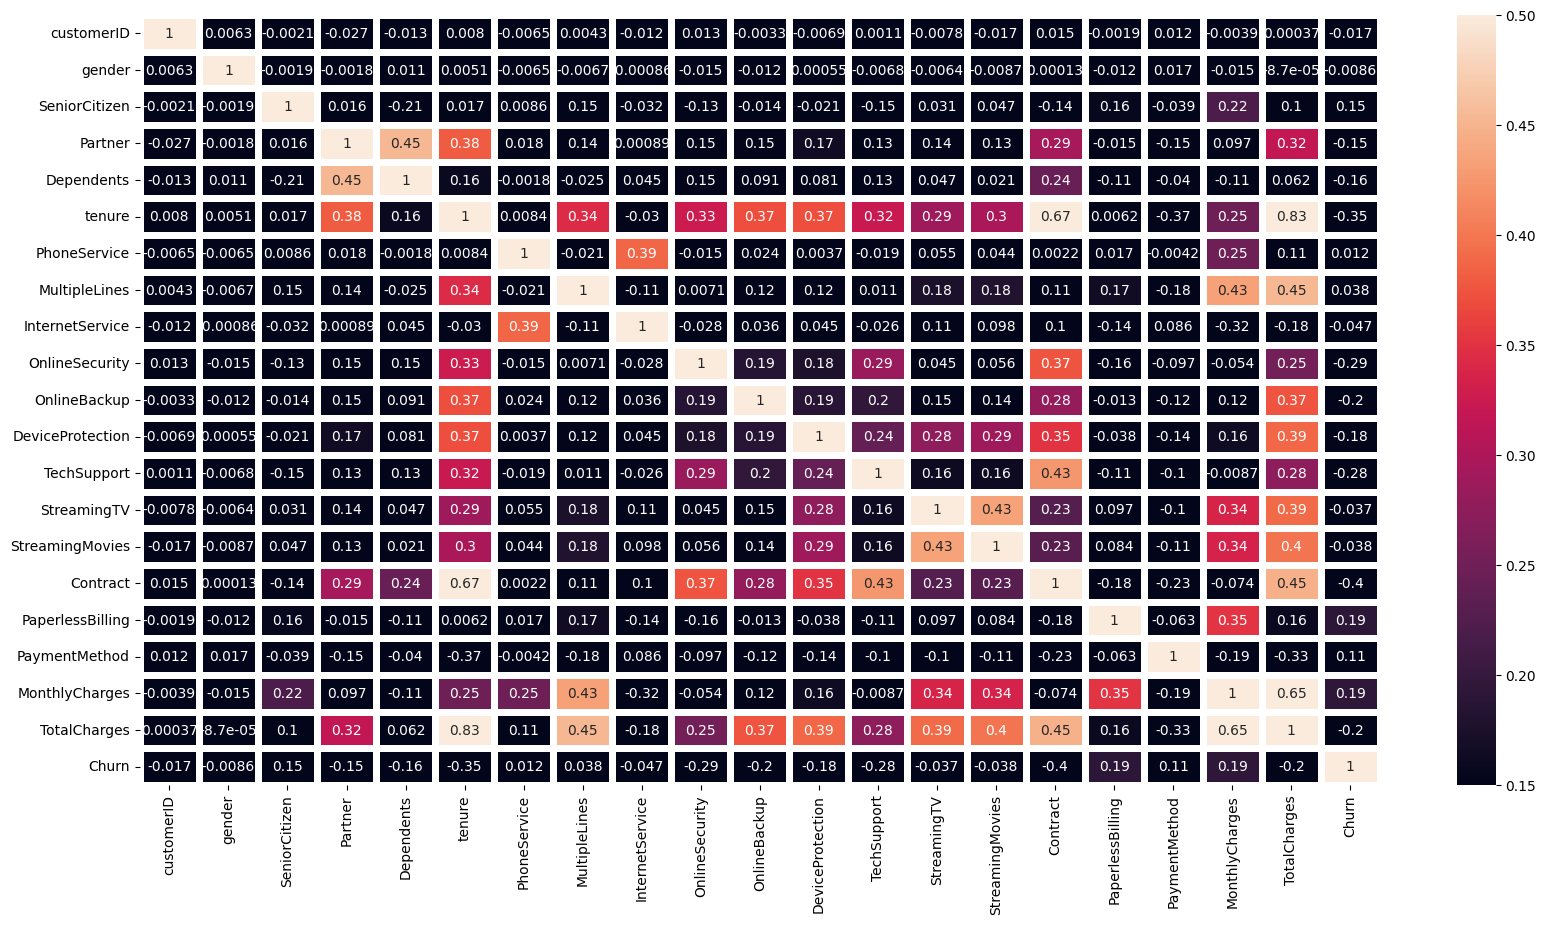

In [17]:
plt.figure(figsize = (20, 10))
sns.heatmap(telco.corr(), linewidths = 5, vmin = 0.15, vmax = 0.5, annot = True)
plt.yticks(rotation = 0);

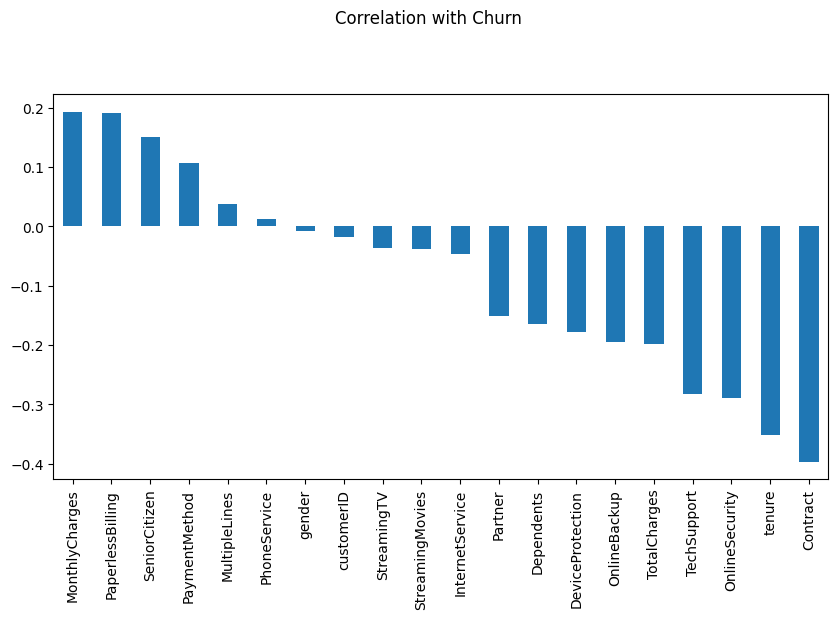

In [18]:
plt.figure(figsize = (10, 5))
telco.corr()["Churn"].sort_values(ascending = False)[1:].plot(kind = "bar");

plt.suptitle("Correlation with Churn", x = 0.5, y = 1.05, ha = "center")
plt.show()

In [19]:
barTrace = go.Bar(x = telco.corr()["Churn"].sort_values(ascending=False)[1:].index,
                  y = telco.corr()["Churn"].sort_values(ascending=False)[1:].values)

fig = go.Figure(barTrace)

fig.update_layout(title = "Correlation of Features with Churn", title_x = 0.5,
                  xaxis = dict(title = "Features", tickangle = 45, tickmode = "array",
                               tickvals = telco.corr()["Churn"].sort_values(ascending=False)[1:].index),
                  yaxis = dict(title = "Correlation with Churn"), height = 600, width = 1200)

fig.show()

In [20]:
numRows = math.ceil(len(telco2.columns[1:]) / 3)
fig = make_subplots(rows = numRows, cols = 3, subplot_titles = telco2.columns[1:], vertical_spacing = 0.1)

for i, column in enumerate(telco2.columns[1:]):
    row = i // 3 + 1
    col = i % 3 + 1

    hist_trace = go.Histogram(x = telco2[column], name = column, marker = dict(line = dict(color = "black", width = 1)))
    fig.add_trace(hist_trace, row = row, col = col)

fig.update_layout(height = numRows * 400, width = 1200, showlegend = False)
fig.show()

In [21]:
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ["Tenure", "Monthly Charges", "Total Charges"])

fig.add_trace(go.Box(y = telco["tenure"], name = "Tenure"), row = 1, col = 1)
fig.add_trace(go.Box(y = telco["MonthlyCharges"], name = "Monthly Charges"), row = 1, col = 2)
fig.add_trace(go.Box(y = telco["TotalCharges"], name = "Total Charges"), row = 1, col = 3)

fig.update_layout(height = 500, width = 1200, showlegend = False)
fig.show()

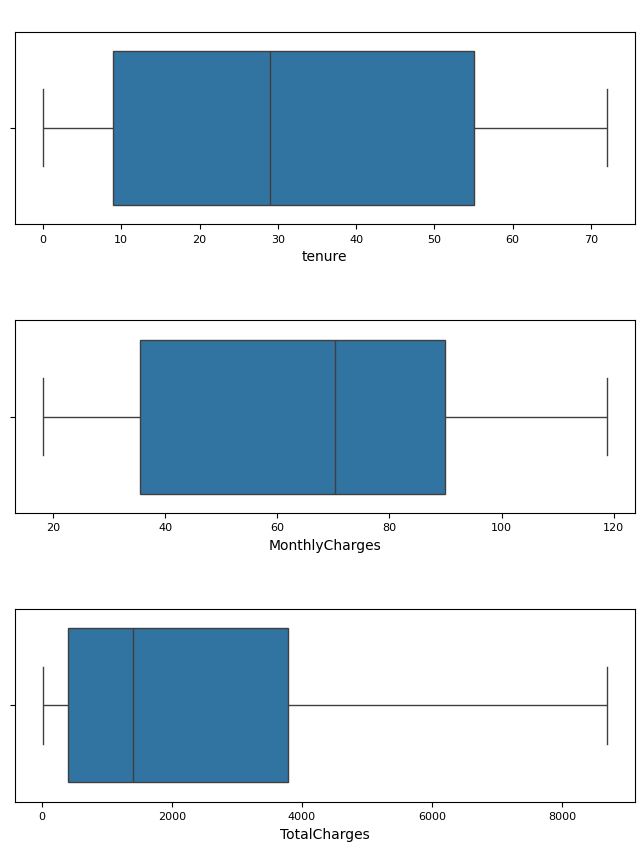

In [22]:
fig, axes = plt.subplots(3, 1, figsize = (8, 10))

for ax in axes:
    ax.tick_params(axis = "x", labelsize = 8)
    ax.tick_params(axis = "y", labelsize = 8)
    ax.set_title(" ", fontsize = 12)

plt.subplots_adjust(hspace = 0.5)

tenure = sns.boxplot(x = telco2["tenure"], ax = axes[0])
monthlyCharges = sns.boxplot(x = telco2["MonthlyCharges"], ax = axes[1])
totalCharges = sns.boxplot(x = telco2["TotalCharges"], ax = axes[2])

plt.show()

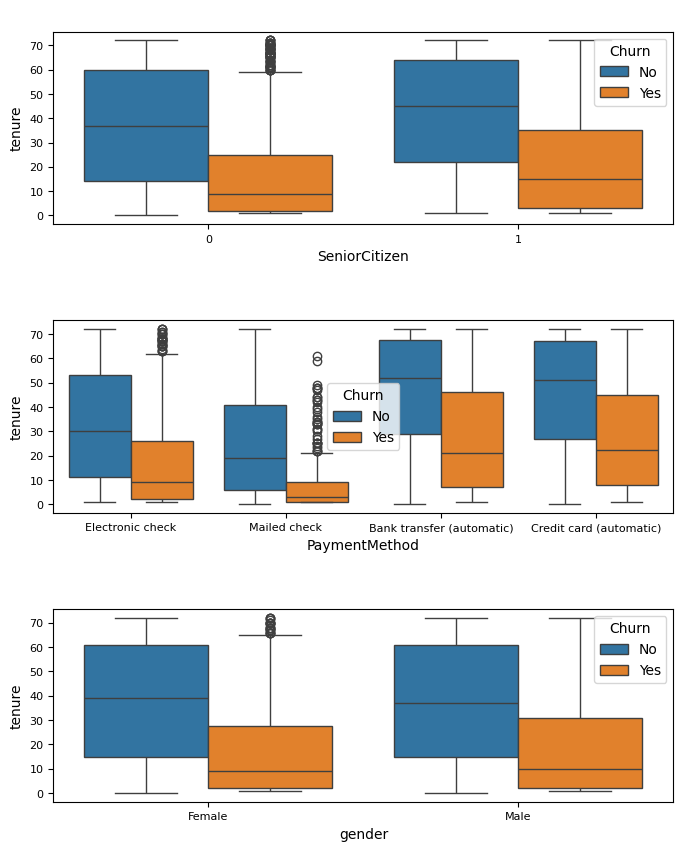

In [23]:
fig, axes = plt.subplots(3, 1, figsize = (8, 10))

for ax in axes:
    ax.tick_params(axis = "x", labelsize = 8)
    ax.tick_params(axis = "y", labelsize = 8)
    ax.set_title(" ", fontsize = 12)

plt.subplots_adjust(hspace = 0.5)

seniorCitizen = sns.boxplot(x = telco2["SeniorCitizen"], y = telco2["tenure"], hue = telco2["Churn"], ax = axes[0])
paymentMethod = sns.boxplot(x = telco2["PaymentMethod"], y = telco2["tenure"], hue = telco2["Churn"], ax = axes[1])
gender = sns.boxplot(x = telco2["gender"], y = telco2["tenure"], hue = telco2["Churn"], ax = axes[2])

plt.show()

**Most important variables (feature importance) that affect the target label.**

Some of the more important features that result in lower churn (in no particular order) include having a partner, dependents, longer tenures, shorter contract types, non-paperless billing, and payment method. Automatic bank transfers churned the least, followed by automatic credit card payments, electronic check payments, and mailed check payments which churned by far the most.

**Splitting the dataset into training and test datasets (80/20 ratio).**

In [24]:
X = telco.drop(["Churn", "customerID"], axis = 1)
y = telco["Churn"]

In [25]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(X, test_size = 0.20, random_state = 0)

print(train.shape)
print(test.shape)

(5634, 19)
(1409, 19)


**Using SweetViz's "compare" command, contrast the training vs test datasets on the target ("churn").**

In [26]:
import sweetviz as sv
sv.compare(train, test).show_html("Compare.html")

                                             |          | [  0%]   00:00 -> (? left)

Report Compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


**Data Preprocessing**

Data imputation, feature selection, and scaling. Encode categorical features.


In [27]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

print(X.shape)
print(train.shape)
print(test.shape)
print(y.shape)

(7043, 19)
(5634, 19)
(1409, 19)
(7043,)


In [28]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = SelectKBest(chi2, k = 5).fit_transform(X, y)
X = scaler.fit_transform(X)
X.shape

(7043, 5)

**Fit models on original dataset, and build each model independently via default parameters.**

In [29]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = 0.20, random_state = 0)

**Naïve Bayes (Gaussian), Logistic Regression, Random Forest, and XGBoost**

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

classifiers = {"Gaussian Naive Bayes": GaussianNB(), "Logistic Regression": LogisticRegression(),
               "Random Forest": RandomForestClassifier(), "XGBoost": XGBClassifier()}

results = pd.DataFrame(columns =["Classifier", "y", "Accuracy", "Precision", "Recall", "F1-Score"])

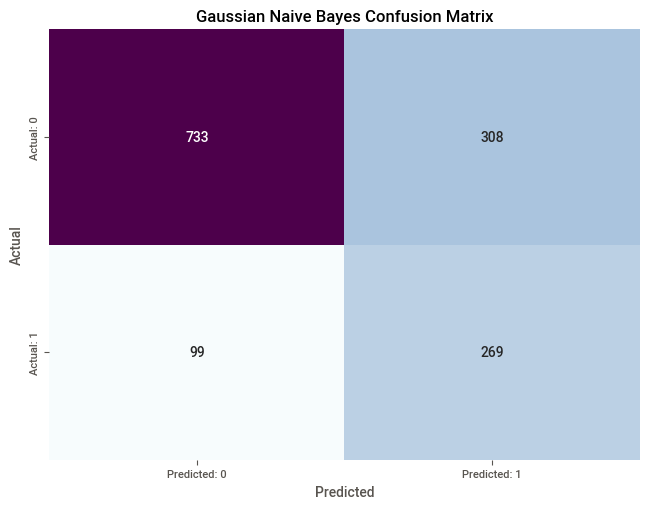

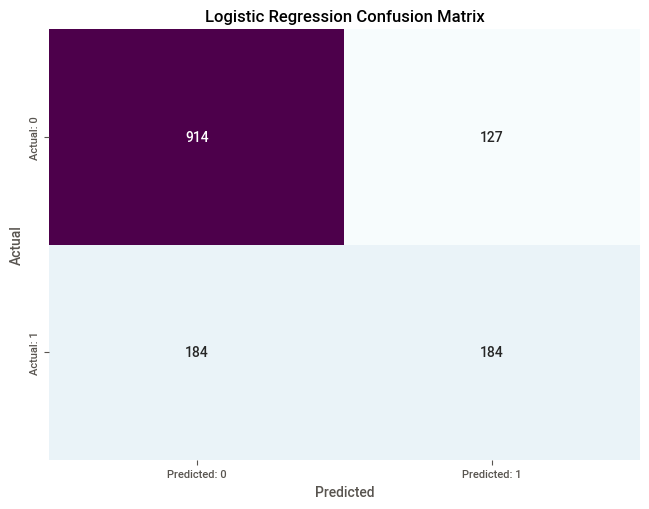

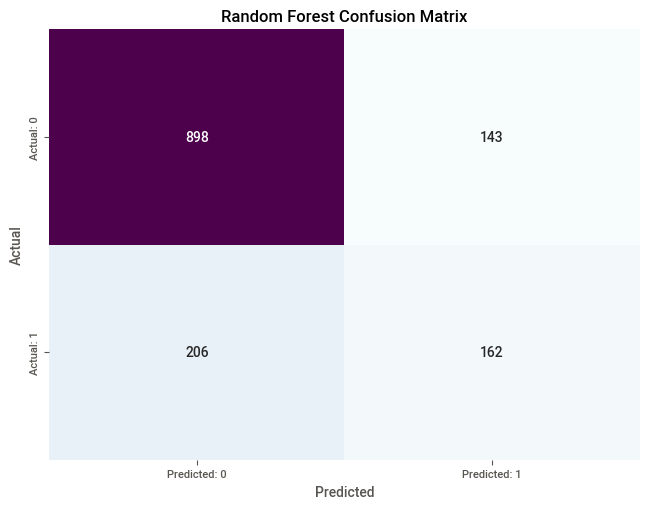

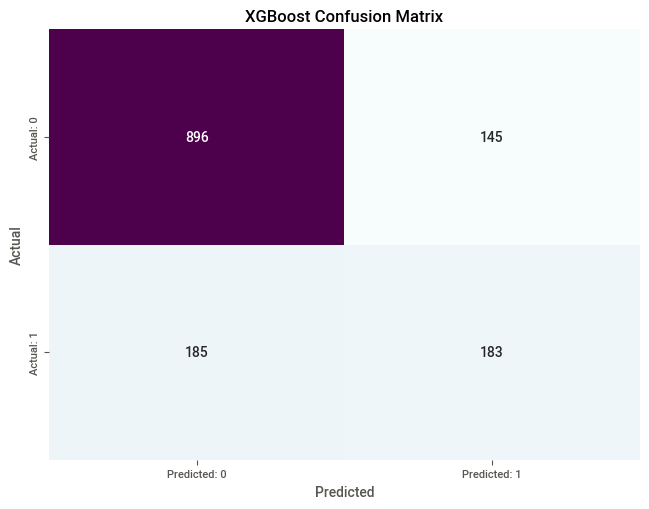

In [31]:
def plotConfusionMatrixWithModels(classifiers, XTrain, XTest, yTrain, yTest):
    for classifier in classifiers:
        classifiers[classifier].fit(XTrain, yTrain)
        yPred = classifiers[classifier].predict(XTest)
        
        cm = confusion_matrix(yTest, yPred)

        sns.heatmap(cm, annot = True, fmt = "d", cmap = "BuPu", cbar = False, xticklabels = ["Predicted: 0", "Predicted: 1"],
                    yticklabels = ["Actual: 0", "Actual: 1"])
        
        plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{classifier} Confusion Matrix")
        plt.show()

confusionMatrixWithModels1 = plotConfusionMatrixWithModels(classifiers, XTrain, XTest, yTrain, yTest)

In [32]:
def getResults(results):
        for classifier in classifiers:
                classifiers[classifier].fit(XTrain, yTrain)
                yPred = classifiers[classifier].predict(XTest)
                
                yPred0 = yPred[yTest == 0]
                yTest0 = yTest[yTest == 0]
                accuracy0 = "{:.4f}".format(accuracy_score(yTest0, yPred0))

                yPred1 = yPred[yTest == 1]
                yTest1 = yTest[yTest == 1]
                accuracy1 = "{:.4f}".format(accuracy_score(yTest1, yPred1))

                accuracy = [accuracy0, accuracy1]

                CR = classification_report(yTest, yPred, output_dict = True)
                CR = pd.DataFrame(CR).transpose()[:2]

                for lineNumber in range(len(CR)):
                        newRow = {"Classifier": classifier, "y": lineNumber, "Accuracy": accuracy[lineNumber],
                                  "Precision": "{:.4f}".format(CR["precision"][lineNumber]), "Recall": "{:.4f}".
                                  format(CR["recall"][lineNumber]), "F1-Score": "{:.4f}".format(CR["f1-score"][lineNumber])}
            
                        results = pd.concat([results, pd.DataFrame([newRow])], ignore_index=True)

        return results
            
getResults(results)

Classifier  y Accuracy Precision  Recall F1-Score
0  Gaussian Naive Bayes  0   0.7041    0.8810  0.7041   0.7827
1  Gaussian Naive Bayes  1   0.7310    0.4662  0.7310   0.5693
2   Logistic Regression  0   0.8780    0.8324  0.8780   0.8546
3   Logistic Regression  1   0.5000    0.5916  0.5000   0.5420
4         Random Forest  0   0.8674    0.8179  0.8674   0.8420
5         Random Forest  1   0.4538    0.5475  0.4538   0.4963
6               XGBoost  0   0.8607    0.8289  0.8607   0.8445
7               XGBoost  1   0.4973    0.5579  0.4973   0.5259

**Tuning Random Forest and XGBoost**

In [33]:
rf = RandomForestClassifier().fit(XTrain, yTrain)
rfYPred = rf.predict(XTest)

print("Feature Importance of Random Forest with Parameters: \n")
for name, score in zip(telco2, rf.feature_importances_):
    print(name, score)

Feature Importance of Random Forest with Parameters: 

customerID 0.18977108334225057
gender 0.062174412082329156
SeniorCitizen 0.11226972490414397
Partner 0.32627403156991847
Dependents 0.30951074810135776


In [34]:
xgb = XGBClassifier().fit(XTrain, yTrain)
xgbYPred = xgb.predict(XTest)

print("\n Feature Importance of XGBoost Classifier with Parameters: \n")
for name, score in zip(telco2, xgb.feature_importances_):
    print(name, score)


 Feature Importance of XGBoost Classifier with Parameters: 

customerID 0.04991047
gender 0.16270149
SeniorCitizen 0.7087539
Partner 0.043402247
Dependents 0.035231896


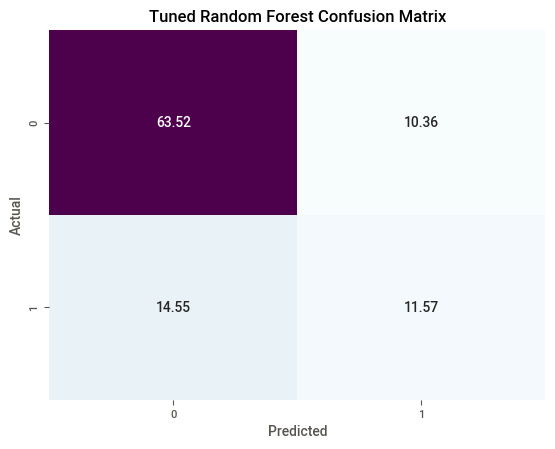

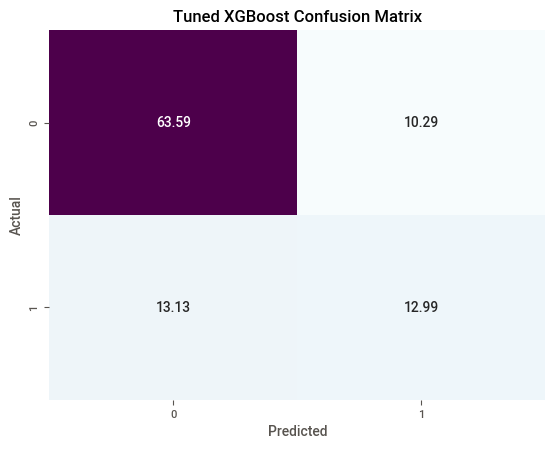

In [35]:
def plotConfusionMatrix(yTest, yPred, title):
    cm = (confusion_matrix(yTest, yPred) / confusion_matrix(yTest, yPred).astype(float).sum()) * 100
    sns.heatmap(cm, annot = True, fmt = ".2f", cmap = "BuPu", cbar = False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

RF1 = plotConfusionMatrix(yTest, rfYPred, "Tuned Random Forest Confusion Matrix")
XGB1 = plotConfusionMatrix(yTest, xgbYPred, "Tuned XGBoost Confusion Matrix")

In [36]:
print("Random Forest Tuned: \n", classification_report(yTest, rfYPred))
print("XGBoost Tuned: \n", classification_report(yTest, xgbYPred))

Random Forest Tuned: 
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      1041
           1       0.53      0.44      0.48       368

    accuracy                           0.75      1409
   macro avg       0.67      0.65      0.66      1409
weighted avg       0.74      0.75      0.74      1409

XGBoost Tuned: 
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1041
           1       0.56      0.50      0.53       368

    accuracy                           0.77      1409
   macro avg       0.69      0.68      0.69      1409
weighted avg       0.76      0.77      0.76      1409



**Comparing the two stages of analysis**

NB 0.7628383233532934
LR 0.5222954091816367
RF 0.4990086493679308
XGB 0.5043433133732534
[array([0.782     , 0.764     , 0.74251497]), array([0.512     , 0.498     , 0.55688623]), array([0.504     , 0.506     , 0.48702595]), array([0.524     , 0.504     , 0.48502994])]


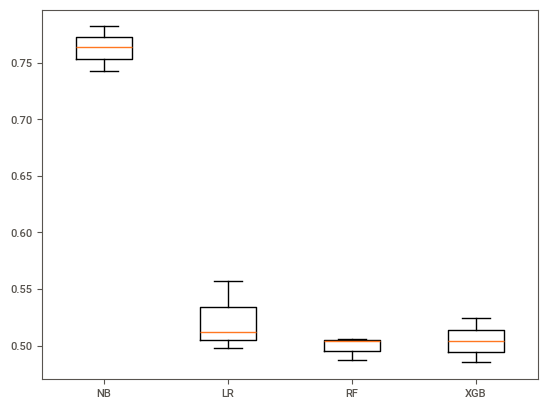

In [37]:
from sklearn.model_selection import cross_val_score

def classificationModels(XTrain, yTrain):
    models = [("NB", GaussianNB()),
              ("LR", LogisticRegression()),
              ("RF", RandomForestClassifier()),
              ("XGB", XGBClassifier())]

    modelOutcomes = []
    modelNames = []

    for name, model in models:
        results = cross_val_score(model, XTrain, yTrain, cv = 3, scoring = "recall", n_jobs = -1, verbose = 0)
        print(name, results.mean())
        modelOutcomes.append(results)
        modelNames.append(name)

    print(modelOutcomes)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.boxplot(modelOutcomes)
    ax.set_xticklabels(modelNames)

classificationModels1 = classificationModels(XTrain, yTrain)

In [38]:
import plotly.graph_objects as go

def classificationModelsWithGo(XTrain, yTrain):
    models = [("NB", GaussianNB()),
              ("LR", LogisticRegression()),
              ("RF", RandomForestClassifier()),
              ("XGB", XGBClassifier())]

    modelOutcomes = []
    modelNames = []
    
    for name, model in models:
        results = cross_val_score(model, XTrain, yTrain, cv = 3, scoring = "recall", n_jobs = -1, verbose = 0)
        print(name, results.mean())
        modelOutcomes.append(results)
        modelNames.append(name)

    print(modelOutcomes)

    fig = go.Figure()
    for modelname, modeloutcome in zip(modelNames, modelOutcomes):
      fig.add_trace(go.Box(y = modeloutcome, name = modelname))

    fig.update_layout(xaxis = dict(tickmode = "array", tickvals = list(range(len(modelNames))), ticktext = modelNames),
                      title = "Model Outcomes", xaxis_title = "Model", yaxis_title = "Recall Score", height = 600, width = 600)
    fig.show()

classificationModelsWithGo1 = classificationModelsWithGo(XTrain, yTrain)

NB 0.7628383233532934
LR 0.5222954091816367
RF 0.5023313373253493
XGB 0.5043433133732534
[array([0.782     , 0.764     , 0.74251497]), array([0.512     , 0.498     , 0.55688623]), array([0.482     , 0.522     , 0.50299401]), array([0.524     , 0.504     , 0.48502994])]


**Applying the SMOTE Technique**

Presenting metric comparison.

In [39]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)

XTrain, yTrain = smote.fit_resample(XTrain, yTrain)

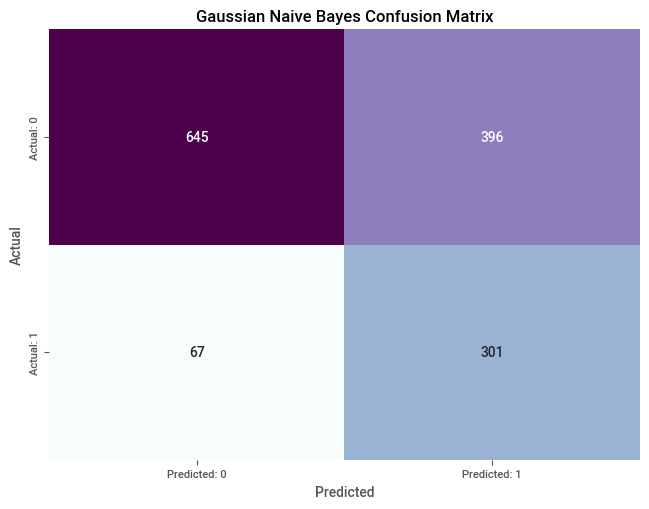

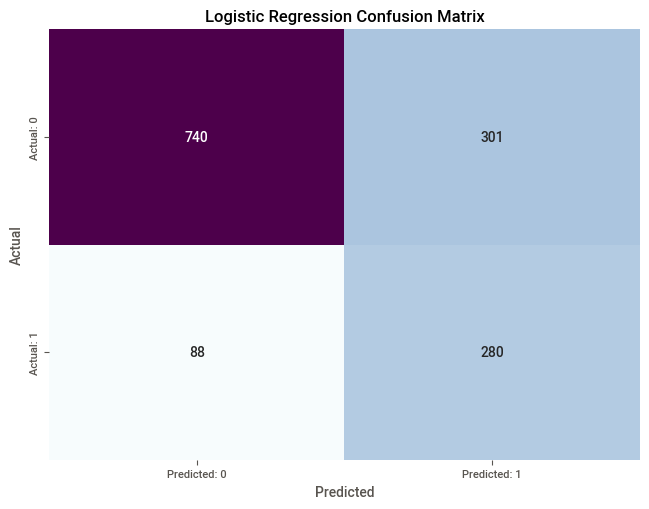

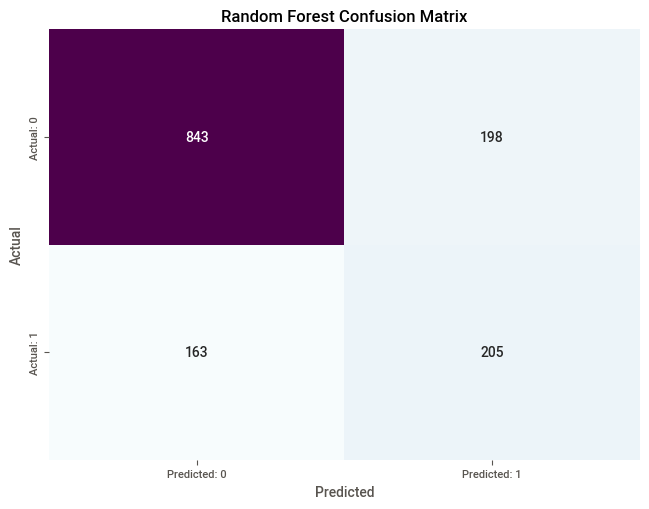

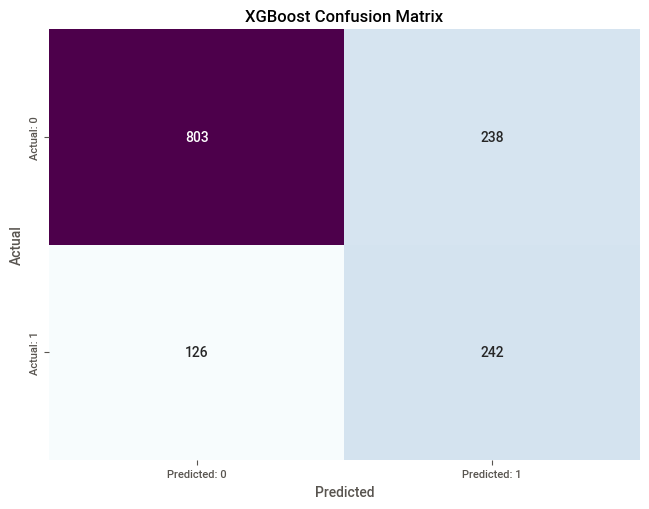

In [40]:
confusionMatrixWithModels2 = plotConfusionMatrixWithModels(classifiers, XTrain, XTest, yTrain, yTest)

In [41]:
getResults(results)

Classifier  y Accuracy Precision  Recall F1-Score
0  Gaussian Naive Bayes  0   0.6196    0.9059  0.6196   0.7359
1  Gaussian Naive Bayes  1   0.8179    0.4319  0.8179   0.5653
2   Logistic Regression  0   0.7109    0.8937  0.7109   0.7919
3   Logistic Regression  1   0.7609    0.4819  0.7609   0.5901
4         Random Forest  0   0.8069    0.8400  0.8069   0.8231
5         Random Forest  1   0.5652    0.5086  0.5652   0.5354
6               XGBoost  0   0.7714    0.8644  0.7714   0.8152
7               XGBoost  1   0.6576    0.5042  0.6576   0.5708

**Hyperparameter tuning Random Forest and XGBoost.**

In [42]:
rf1 = RandomForestClassifier(n_estimators = 300, max_leaf_nodes = 10).fit(XTrain, yTrain)
rf1YPred = rf1.predict(XTest)

print("Feature Importance of Random Forest Classifier with Parameters: \n")
for name, score in zip(telco2, rf1.feature_importances_):
    print(name, score)

Feature Importance of Random Forest Classifier with Parameters: 

customerID 0.1816943383993554
gender 0.1963559141388907
SeniorCitizen 0.45100994083418716
Partner 0.11002731392945712
Dependents 0.06091249269810941


In [43]:
xgb1 = XGBClassifier(n_estimators = 300, max_leaf_nodes = 10)
xgb1.fit(XTrain, yTrain)
xgb1YPred = xgb1.predict(XTest)

print("Feature Importance of XGBoost Classifier with Parameters: \n")
for name, score in zip(telco2, xgb1.feature_importances_):
    print(name, score)

Feature Importance of XGBoost Classifier with Parameters: 

customerID 0.072910905
gender 0.13814703
SeniorCitizen 0.67857873
Partner 0.059310395
Dependents 0.051052824


In [44]:
print("Random Forest Tuned \n", classification_report(yTest, rf1YPred))
print("\nXGBoost Tuned \n", classification_report(yTest, xgb1YPred))

Random Forest Tuned 
               precision    recall  f1-score   support

           0       0.89      0.69      0.78      1041
           1       0.47      0.76      0.58       368

    accuracy                           0.71      1409
   macro avg       0.68      0.73      0.68      1409
weighted avg       0.78      0.71      0.73      1409


XGBoost Tuned 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1041
           1       0.49      0.60      0.53       368

    accuracy                           0.73      1409
   macro avg       0.67      0.69      0.67      1409
weighted avg       0.75      0.73      0.74      1409



**Comparing alternate stage analyses. Algorithm selection & model evaluation.**


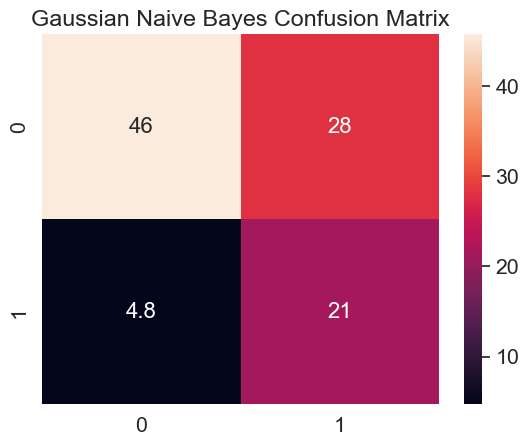

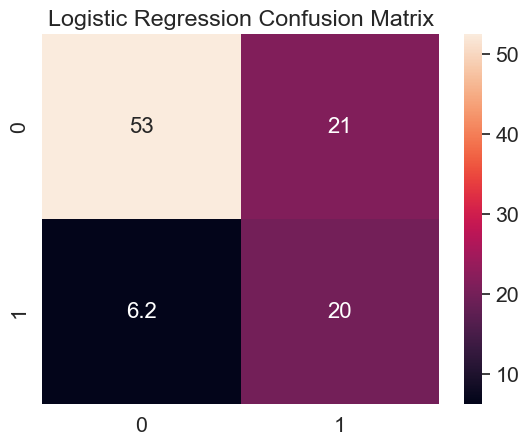

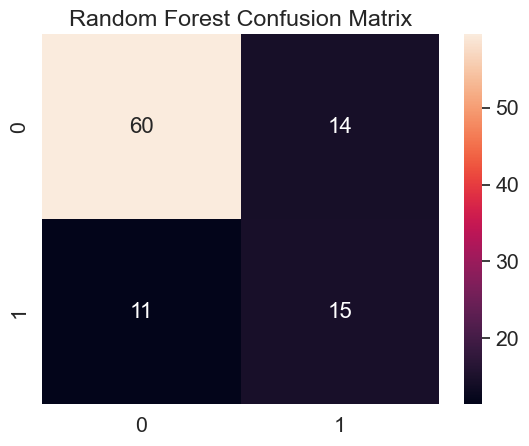

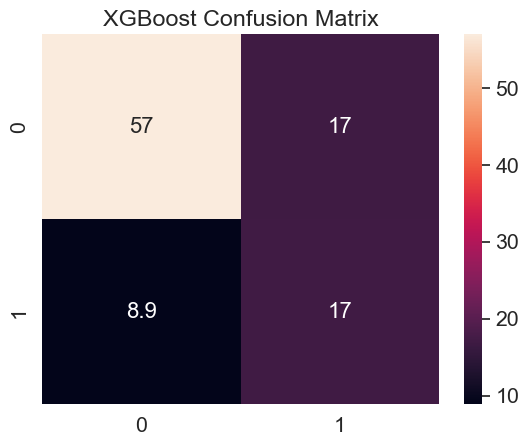

In [45]:
comparison = pd.DataFrame(columns = ["Classifier", "y", "Accuracy", "Precision", "Recall", "F1-Score"])

for classifier in classifiers.keys():
    classifiers[classifier].fit(XTrain, yTrain)
    yPred = classifiers[classifier].predict(XTest)
    cm = (confusion_matrix(yTest, yPred) / confusion_matrix(yTest, yPred).astype(float).sum()) * 100
    comparison_cm = pd.DataFrame(cm, range(len(cm[0])), range(len(cm[0])))
    sns.set(font_scale = 1.4)
    sns.heatmap(comparison_cm, annot = True, annot_kws = {"size": 16})
    plt.title("{classifier} Confusion Matrix".format(classifier = classifier))
    plt.show()

NB 0.8509555876678827
LR 0.8042569211024014
RF 0.8359581823017512
XGB 0.8330573570430518
[array([0.84397678, 0.85039942, 0.85849057]), array([0.79317852, 0.79811184, 0.82148041]), array([0.76197388, 0.85112564, 0.89477504]), array([0.76342525, 0.85911402, 0.8766328 ])]


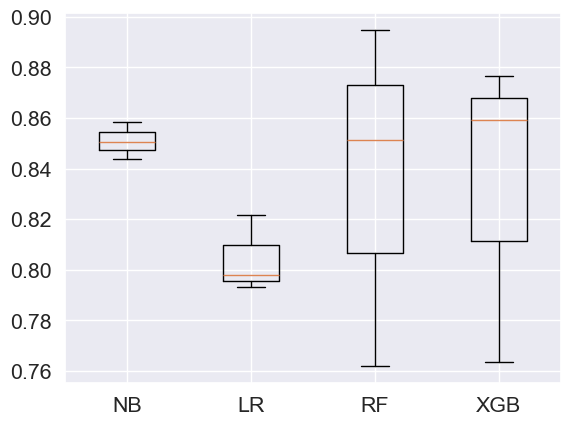

In [46]:
classificationModels(XTrain, yTrain)

In [47]:
classificationModelsWithGo(XTrain, yTrain)

NB 0.8509555876678827
LR 0.8042569211024014
RF 0.8320883658163224
XGB 0.8330573570430518
[array([0.84397678, 0.85039942, 0.85849057]), array([0.79317852, 0.79811184, 0.82148041]), array([0.75761974, 0.85330428, 0.88534107]), array([0.76342525, 0.85911402, 0.8766328 ])]
